In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1. Pandas | Pre-procesamiento

Utilizaremos una base de datos sobre países para tareas de pre-procesamiento

In [2]:
import sqlite3
import pandas as pd

In [3]:
conn = sqlite3.connect("countries_new.db")
# TABLES: all_countries, currencies

In [4]:
# se utilizará la tabla all_countries
query = "SELECT * FROM all_countries"

In [5]:
df_countries = pd.read_sql_query(query, con=conn)
df_countries.sample(5)

,country_code,country_name,country_alpha3_code,country_numeric_code,capital,country_demonym,total_area,population,currency_code,lang_code
112,BZ,Belize,BLZ,NaN,Belmopan,Belizeans,22966.0,382444.0,BZD,EN
5,NL,Netherlands,NLD,NaN,Amsterdam,Netherlanders,41543.0,17110161.0,EUR,NL
253,MC,Monaco,MCO,NaN,Monaco,Monacans,2.0,38897.0,EUR,FR
175,KZ,Kazakhstan,KAZ,NaN,Astana,Kazakhstanis,2724900.0,18403860.0,KZT,RU
249,BG,Bulgaria,BGR,NaN,Sofia,Bulgarians,NaN,NaN,BGN,GB


### 1.1 Estadisticas generales sobre el dataset

In [6]:
df_countries.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_code,262,249,GL,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_name,262,249,Haiti,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_alpha3_code,221,212,BGR,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_numeric_code,40,NaN,NaN,NaN,490.625,252.082,10,362,510,677.5,894
capital,262,241,-,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_demonym,260,241,British,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_area,226,NaN,NaN,NaN,611492,1.92084e+06,0.44,1942.5,65455,444858,1.70982e+07
population,220,NaN,NaN,NaN,3.30171e+07,1.37539e+08,0,189792,4.80375e+06,1.83143e+07,1.41505e+09
currency_code,261,153,EUR,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lang_code,262,63,EN,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 Filas/Países repetidos

Cada código de país, debería aparecer una sola vez

In [7]:
df_countries.shape[0], len(df_countries.country_code.unique())

(262, 249)

In [8]:
#Eliminar las filas repetidas
df_countries.drop_duplicates(subset ="country_code", keep = 'first', inplace = True)
df_countries.shape

(249, 10)

### 1.3 Tratamiento de valores faltantes

In [9]:
df_countries.isnull().sum()

country_code              0
country_name              0
country_alpha3_code      37
country_numeric_code    209
capital                   0
country_demonym           2
total_area               30
population               39
currency_code             1
lang_code                 0
dtype: int64

##### 1.3.1 Eliminar la columna country_numeric_code

In [10]:
df_countries = df_countries.drop(['country_numeric_code'], axis=1)

In [11]:
df_countries.sample()

,country_code,country_name,country_alpha3_code,capital,country_demonym,total_area,population,currency_code,lang_code
246,SV,El Salvador,SLV,San Salvador,Salvadorans,21041.0,6411558.0,NOK,ES


##### 1.3.2 Rellenar NANs en la columna total_area

In [12]:
total_area_mean = df_countries.total_area.mean()
total_area_mean

601698.9175342466

In [13]:
df_countries.total_area.fillna(total_area_mean, inplace=True)

##### 1.3.3 Rellenar NaNs en la columna population

In [14]:
population_mean = df_countries.population.mean()
population_mean

32923422.276190475

In [15]:
df_countries.population.fillna(population_mean, inplace=True)

##### 1.3.4 Rellenar NaNs en la columna country_alpha3_code

In [16]:
df_countries.country_alpha3_code.fillna('-', inplace=True)

____

# 2. Visualización de datos

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

En la parte de visualización de datos, se utilizará el Exchanges Rates API https://exchangeratesapi.io/ para obtener los tipos de cambio respecto al dolar para el mes de Julio del 2019

In [18]:
import requests
import numpy as np

In [19]:
endpoint = f"""
https://api.exchangeratesapi.io/history
    ? start_at=2019-07-01
    & end_at=2019-07-30
    & base=USD
"""

In [20]:
endpoint = endpoint.replace('\n', '')
endpoint = endpoint.replace(' ', '')
endpoint

'https://api.exchangeratesapi.io/history?start_at=2019-07-01&end_at=2019-07-30&base=USD'

In [21]:
response = requests.get(endpoint)
response.status_code, response.reason

(200, 'OK')

In [22]:
import json
json_string = response.content.decode()
data = json.loads(json_string)
#solo utilizar el campo rates del diccionario obtenido como respuesta
exchange_df = pd.DataFrame(data['rates']).T
#es necesario ordenar las fechas
exchange_df = exchange_df.sort_index()
#22 días (solo se toman en cuenta días hábiles) para 33 monedas
exchange_df.shape

(22, 33)

### 2.1 Comparación entre las medias del tipo de cambio de todas las monedas

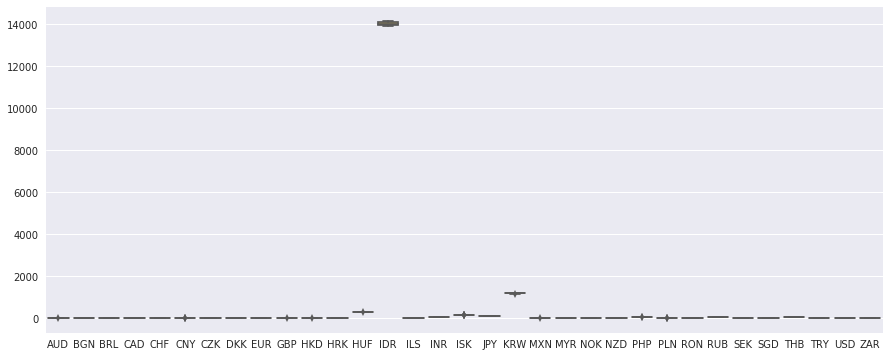

In [23]:
#Que no hacer
plt.figure(figsize=(15,6))
sns.boxplot(data=exchange_df, orient="v", palette="Set2")

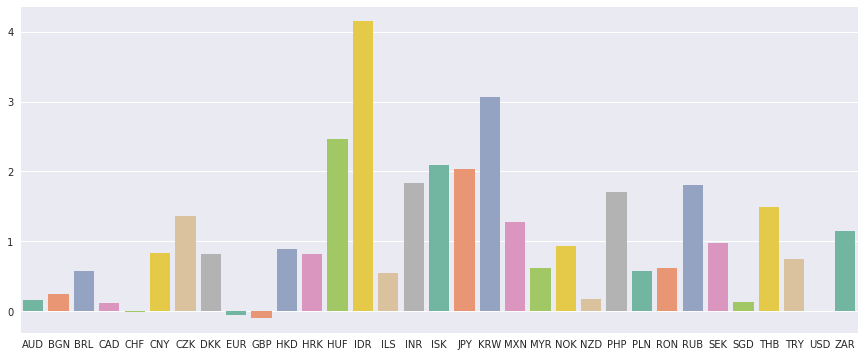

In [24]:
exchange_means = np.mean(exchange_df)
plt.figure(figsize=(15,6))
sns.barplot(x=exchange_means.index, y=np.log10(exchange_means.values) , orient="v", palette="Set2")

### 2.2 Comparación entre el tipo de cambio del Euro y la Libra Esterlina

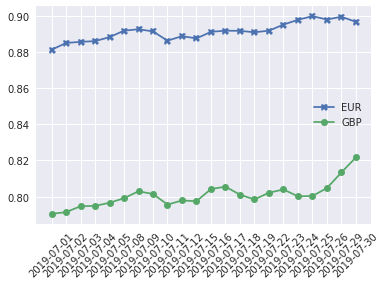

In [25]:
plt.plot(exchange_df.EUR, marker='X')
plt.plot(exchange_df.GBP, marker='o')
plt.xticks(rotation=45)
plt.legend(['EUR', 'GBP'], loc=0)

### 2.3 ¿Habrá correlaciones entre los tipos de cambio de las diferentes monedas?

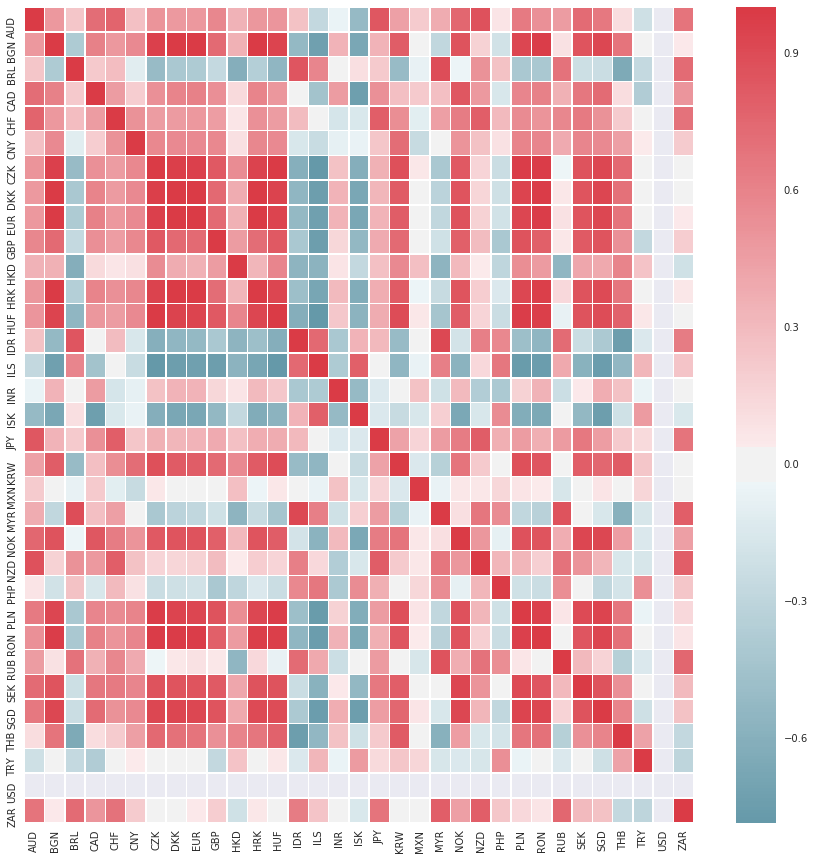

In [26]:
corr = exchange_df.corr()
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, linewidths=.5)

##### Graficar un caso donde haya mucha correlación y otro donde ocurra lo contrario

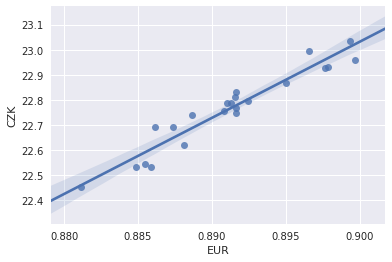

In [27]:
sns.regplot(exchange_df.EUR, exchange_df.CZK)

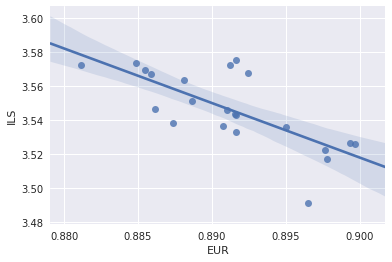

In [28]:
sns.regplot(exchange_df.EUR, exchange_df.ILS)